In [ ]:
pip install PyPortfolioOpt

In [ ]:
pip install yfinance

In [ ]:
pip install pulp

In [ ]:
pip install quandl

In [ ]:
#Hierarchical Risk Parity (Lopez de Prado 2016)

import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import matplotlib

In [ ]:
df= pd.read_csv("capstone_input_data.csv")
df.Date = pd.to_datetime(df.Date, dayfirst = True)
df.set_index("Date", inplace = True)
returns=df.pct_change()
returns.head()

,SBIN.NS,TATAMOTORS.NS,RELIANCE.NS,LT.NS,TATASTEEL.NS
Date,,,,,
2015-08-03,NaN,NaN,NaN,NaN,NaN
2015-08-04,0.026864,-0.019191,-0.014415,-0.002613,0.033676
2015-08-05,-0.011088,-0.011425,-0.000253,0.002733,0.023410
2015-08-06,0.012789,0.017800,-0.008909,0.028743,-0.004956
2015-08-07,-0.026812,0.026886,0.005516,0.001475,0.004023


In [ ]:
returns.columns

Index(['SBIN.NS', 'TATAMOTORS.NS', 'RELIANCE.NS', 'LT.NS', 'TATASTEEL.NS'], dtype='object')

In [ ]:
# correlation matrix
corr_matrix = returns.corr()
# distance matrix
dist_corr = np.sqrt(0.5*(1-corr_matrix))

In [ ]:
# correlation matrix
# corr replaced by corr_matrix = returns.corr() 
# distance matrix
# d_corr replaced by dist_corr = np.sqrt(0.5*(1-corr))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


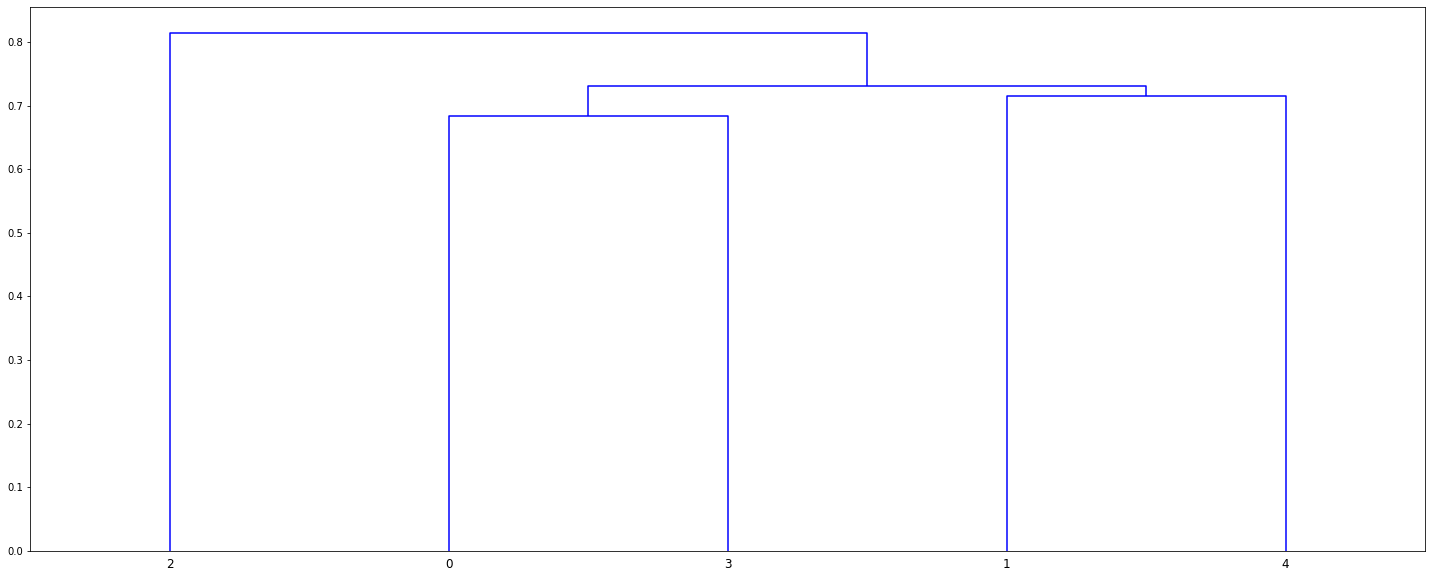

In [ ]:
# Performing hierarchical/agglomerative clustering.
linkage = linkage(dist_corr, 'single')
Ze = pd.DataFrame(linkage)

fig = plt.figure(figsize=(25, 10))
dendogram = dendrogram(Ze)
# plt.show()

In [ ]:
Ze

,0,1,2,3
0,0.0,3.0,0.683805,2.0
1,1.0,4.0,0.716019,2.0
2,5.0,6.0,0.730618,4.0
3,2.0,7.0,0.814331,5.0


In [ ]:
def quasi_diagonalization(linkage):
    
    # The clustered items are sorted based on their distance
    
    linkage = linkage.astype(int)
    
    # The last quadriplets first and second consituent items are taken
    sort_last = pd.Series([linkage[-1,0], linkage[-1,1]]) 
    
    # The third element of the constituent set represents the total items
    num_items = linkage[-1, 3]
    
  
    # if the max_times is less than or equal to the maximum of sort_last
    while sort_last.max() >= num_items:
        # we assign a 24 by 24 sort_last index 
        sort_last.index = range(0, sort_last.shape[0]*2, 2) 
        # the odd numbers are indexed
        
        df0 = sort_last[sort_last >= num_items] # finding clusters
        
      
        # the cluster and even index are contained in df0
        i = df0.index
        j = df0.values - num_items  
        
        sort_last[i] = linkage[j,0] # item#1
        
        df0  = pd.Series(linkage[j, 1], index=i+1)
        
        sort_last = sort_last.append(df0)
        sort_last = sort_last.sort_index()
        
        sort_last.index = range(sort_last.shape[0])
        
    
    return sort_last.tolist()

In [ ]:
sort_last = quasi_diagonalization(linkage)
sort_last

[2, 0, 3, 1, 4]

In [ ]:
def cluster_variable(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # slice of matrix
    # now we calculate the inverse variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var

def recursive_bisection(cov, sort_last):
    # computing Hierarchical Risk Parity allocation
    # intializing weights of one
    w = pd.Series(1, index=sort_last)
    
    # intializing all items in a single cluster
    c_items = [sort_last]
    while len(c_items) > 0:
        # recursive bisection
        """
        [[3, 6, 0, 9, 2, 4, 13], [5, 12, 8, 10, 7, 1, 11]]
        [[3, 6, 0], [9, 2, 4, 13], [5, 12, 8], [10, 7, 1, 11]]
        [[3], [6, 0], [9, 2], [4, 13], [5], [12, 8], [10, 7], [1, 11]]
        [[6], [0], [9], [2], [4], [13], [12], [8], [10], [7], [1], [11]]
        """
        c_items = [i[int(j):int(k)] for i in c_items for j,k in 
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]
        
        # now it has 2
        for i in range(0, len(c_items), 2):
            
            c_items0 = c_items[i] # first cluster
            c_items1 = c_items[i+1] # second cluster
            
            c_var0 = cluster_variable(cov, c_items0)
            c_var1 = cluster_variable(cov, c_items1)
            
            alpha = 1 - c_var0/(c_var0+c_var1)
            
            w[c_items0] *= alpha
            w[c_items1] *=1-alpha
    return w

In [ ]:
covariance = returns.cov()
weights = recursive_bisection(covariance, sort_last)

In [ ]:
new_index = [returns.columns[i] for i in weights.index]
weights.index = new_index

In [ ]:
weights

RELIANCE.NS      0.317518
SBIN.NS          0.202151
LT.NS            0.302281
TATAMOTORS.NS    0.072657
TATASTEEL.NS     0.105393
dtype: float64